In [1]:
import sys
sys.path.append("../../src")
import os
import numpy as np
import pickle
from example_lorenz import get_lorenz_data, generate_lorenz_data
from tf_autoencoder import full_network
from tf_training import create_feed_dictionary
from sindy_utils import sindy_simulate
import tensorflow as tf
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [2]:
data_path = os.getcwd() + '/'
save_name = 'model1'
params = pickle.load(open(data_path + save_name + '_params.pkl', 'rb'))
params['save_name'] = data_path + save_name

autoencoder_network = full_network(params)
learning_rate = tf.placeholder(tf.float32, name='learning_rate')
saver = tf.train.Saver(var_list=tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES))

tensorflow_run_tuple = ()
for key in autoencoder_network.keys():
    tensorflow_run_tuple += (autoencoder_network[key],)




The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.






## Single trajectory plots

In [3]:
t = np.arange(0,20,.01)
z0 = np.array([[-8,7,27]])

test_data = generate_lorenz_data(z0, t, params['input_dim'], linear=False, normalization=np.array([1/40,1/40,1/40]))
test_data['x'] = test_data['x'].reshape((-1,params['input_dim']))
test_data['dx'] = test_data['dx'].reshape((-1,params['input_dim']))
test_data['z'] = test_data['z'].reshape((-1,params['latent_dim']))
test_data['dz'] = test_data['dz'].reshape((-1,params['latent_dim']))

In [4]:
with tf.Session() as sess:
    #sess.run(tf.global_variables_initializer())
    saver.restore(sess, data_path + save_name)
    test_dictionary = create_feed_dictionary(test_data, params)
    tf_results = sess.run(tensorflow_run_tuple, feed_dict=test_dictionary)

test_set_results = {}
for i,key in enumerate(autoencoder_network.keys()):
    test_set_results[key] = tf_results[i]



INFO:tensorflow:Restoring parameters from /Users/aloisduston/Desktop/Math/Research/Kutz/SindyTorchEnconder/tf_model/examples/lorenz/model1


2023-01-13 16:17:26.261603: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-13 16:17:26.261873: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


In [5]:
a1 = 1
a2 = test_data['sindy_coefficients'][2,0]/test_set_results['sindy_coefficients'][2,0]
a3 = np.sqrt(-test_set_results['sindy_coefficients'][5,2]/test_set_results['sindy_coefficients'][6,1]*a2**2)
b3 = -test_set_results['sindy_coefficients'][0,2]/test_set_results['sindy_coefficients'][3,2]

sindy_coefficients_transformed = np.zeros(test_set_results['sindy_coefficients'].shape)
sindy_coefficients_transformed[1,0] = test_set_results['sindy_coefficients'][1,0]
sindy_coefficients_transformed[2,0] = test_set_results['sindy_coefficients'][2,0]*a2/a1
sindy_coefficients_transformed[1,1] = test_set_results['sindy_coefficients'][6,1]*a1/a2*b3
sindy_coefficients_transformed[2,1] = test_set_results['sindy_coefficients'][2,1]
sindy_coefficients_transformed[6,1] = test_set_results['sindy_coefficients'][6,1]*a1*a3/a2
sindy_coefficients_transformed[3,2] = test_set_results['sindy_coefficients'][3,2]
sindy_coefficients_transformed[5,2] = test_set_results['sindy_coefficients'][5,2]*a1*a2/a3

z0_transformed = np.array([test_set_results['z'][0,0]/a1,
                           test_set_results['z'][0,1]/a2,
                           (test_set_results['z'][0,2] - b3)/a3])

In [6]:
lorenz_sim = sindy_simulate(test_data['z'][0], t, test_data['sindy_coefficients'],
                            params['poly_order'], params['include_sine'])
z_sim = sindy_simulate(test_set_results['z'][0], t, params['coefficient_mask']*test_set_results['sindy_coefficients'],
                       params['poly_order'], params['include_sine'])
z_sim_transformed = sindy_simulate(z0_transformed, t, sindy_coefficients_transformed,
                                   params['poly_order'], params['include_sine'])

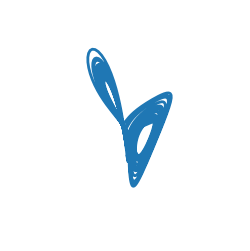

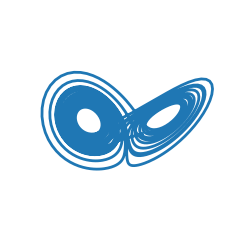

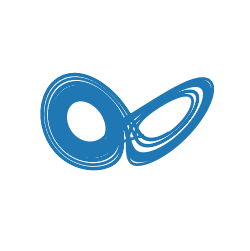

In [7]:
fig1 = plt.figure(figsize=(3,3))
ax1 = fig1.add_subplot(111, projection='3d')
ax1.plot(z_sim[:,0], z_sim[:,1], z_sim[:,2], linewidth=2)
plt.axis('off')
ax1.view_init(azim=120)

fig2 = plt.figure(figsize=(3,3))
ax2 = fig2.add_subplot(111, projection='3d')
ax2.plot(z_sim_transformed[:,0], z_sim_transformed[:,1], z_sim_transformed[:,2], linewidth=2)
plt.axis('off')
ax2.view_init(azim=120)

fig3 = plt.figure(figsize=(3,3))
ax3 = fig3.add_subplot(111, projection='3d')
ax3.plot(lorenz_sim[:,0], lorenz_sim[:,1], lorenz_sim[:,2], linewidth=2)
plt.xticks([])
plt.axis('off')
ax3.view_init(azim=120)

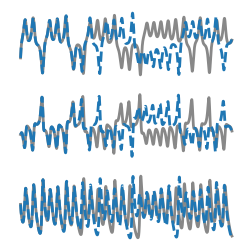

In [8]:
plt.figure(figsize=(3,3))
for i in range(3):
    plt.subplot(3,1,i+1)
    plt.plot(t, test_set_results['z'][:,i], color='#888888', linewidth=2)
    plt.plot(t, z_sim[:,i], '--', linewidth=2)
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')

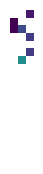

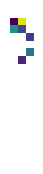

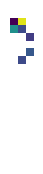

In [9]:
Xi_plot = (params['coefficient_mask']*test_set_results['sindy_coefficients'])
Xi_plot[Xi_plot==0] = np.inf
plt.figure(figsize=(1,2))
plt.imshow(Xi_plot, interpolation='none')
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.clim([-10,30])

Xi_transformed_plot = np.copy(sindy_coefficients_transformed)
Xi_transformed_plot[Xi_transformed_plot==0] = np.inf
plt.figure(figsize=(1,2))
plt.imshow(Xi_transformed_plot, interpolation='none')
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.clim([-10,30])

Xi_true_plot = np.copy(test_data['sindy_coefficients'])
Xi_true_plot[Xi_true_plot==0] = np.inf
Xi_true_plot[6,1] = -1.
Xi_true_plot[5,2] = 1.
plt.figure(figsize=(1,2))
plt.imshow(Xi_true_plot, interpolation='none')
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.clim([-10,30])

## Test set analysis - in distribution

In [10]:
test_data = get_lorenz_data(100, noise_strength=1e-6)

In [11]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, data_path + save_name)
    test_dictionary = create_feed_dictionary(test_data, params)
    tf_results = sess.run(tensorflow_run_tuple, feed_dict=test_dictionary)

test_set_results = {}
for i,key in enumerate(autoencoder_network.keys()):
    test_set_results[key] = tf_results[i]

INFO:tensorflow:Restoring parameters from /Users/aloisduston/Desktop/Math/Research/Kutz/SindyTorchEnconder/tf_model/examples/lorenz/model1


In [12]:
decoder_x_error = np.mean((test_data['x'] - test_set_results['x_decode'])**2)/np.mean(test_data['x']**2)
decoder_dx_error = np.mean((test_data['dx'] - test_set_results['dx_decode'])**2)/np.mean(test_data['dx']**2)
sindy_dz_error = np.mean((test_set_results['dz'] - test_set_results['dz_predict'])**2)/np.mean(test_set_results['dz']**2)

print('Decoder relative error: %f' % decoder_x_error)
print('Decoder relative SINDy error: %f' % decoder_dx_error)
print('SINDy reltive error, z: %f' % sindy_dz_error)

Decoder relative error: 0.000027
Decoder relative SINDy error: 0.000126
SINDy reltive error, z: 0.000553


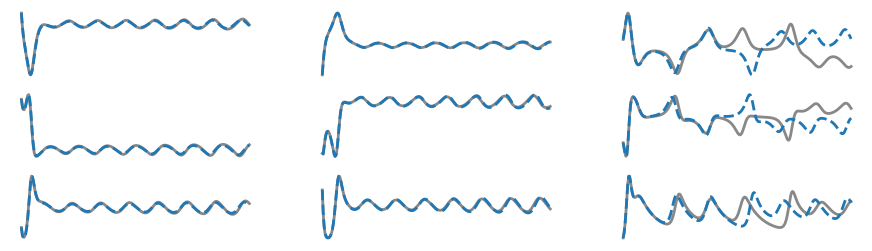

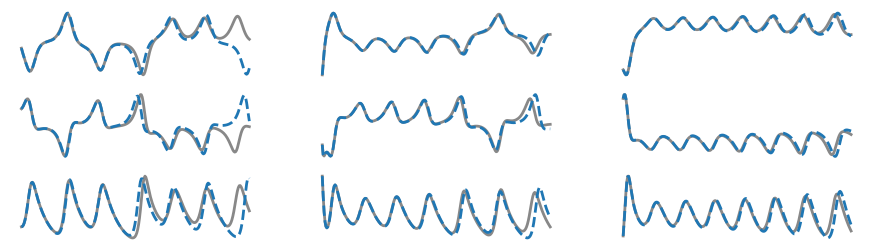

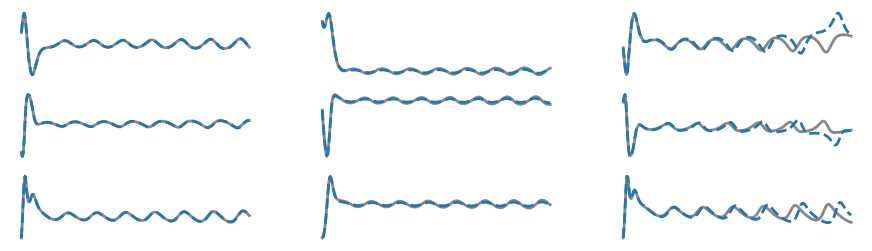

In [13]:
for ic in range(9):
    idxs = np.arange(ic*250,(ic+1)*250)
    
    z_sim = sindy_simulate(test_set_results['z'][250*ic], test_data['t'],
                           params['coefficient_mask']*test_set_results['sindy_coefficients'],
                           params['poly_order'], params['include_sine'])
    
    col_idx = ic % 3
    
    if ic % 3 == 0:
        plt.figure(figsize=(11,3))
    for i in range(3):
        row_idx = i
        subplot_idx = 3*row_idx + col_idx + 1
        plt.subplot(3,3,subplot_idx)
        plt.plot(test_data['t'], test_set_results['z'][idxs,i], color='#888888', linewidth=2)
        plt.plot(test_data['t'], z_sim[:,i], '--', linewidth=2)
        plt.xticks([])
        plt.yticks([])
#         plt.ylim(ylims[i])
        plt.axis('off')

## Test set analysis - out of distribution

In [14]:
inDist_ic_widths = np.array([36,48,41])
outDist_extra_width = np.array([18,24,20])
full_width = inDist_ic_widths + outDist_extra_width

t = np.arange(0, 5, .02)
n_ics = 100

i = 0
ics = np.zeros((n_ics,3))
while i < n_ics:
    
    ic = np.array([np.random.uniform(-full_width[0],full_width[0]),
                   np.random.uniform(-full_width[1],full_width[1]),
                   np.random.uniform(-full_width[2],full_width[2]) + 25])
    if ((ic[0] > -inDist_ic_widths[0]) and (ic[0] < inDist_ic_widths[0])) \
        and ((ic[1] > -inDist_ic_widths[1]) and (ic[1] < inDist_ic_widths[1])) \
        and ((ic[2] > 25-inDist_ic_widths[2]) and (ic[2] < 25+inDist_ic_widths[2])):
        continue
    else:
        ics[i] = ic
        i += 1
        
noise_strength = 1e-6

# training test_data
test_data = generate_lorenz_data(ics, t, params['input_dim'], linear=False, normalization=np.array([1/40,1/40,1/40]))
test_data['x'] = test_data['x'].reshape((-1,params['input_dim']))
test_data['x'] += noise_strength*np.random.normal(size=test_data['x'].shape)
test_data['dx'] = test_data['dx'].reshape((-1,params['input_dim']))
test_data['dx'] += noise_strength*np.random.normal(size=test_data['dx'].shape)

In [15]:
with tf.Session() as sess:
    #sess.run(tf.global_variables_initializer())
    saver.restore(sess, data_path + save_name)
    test_dictionary = create_feed_dictionary(test_data, params)
    tf_results = sess.run(tensorflow_run_tuple, feed_dict=test_dictionary)

test_set_results = {}
for i,key in enumerate(autoencoder_network.keys()):
    test_set_results[key] = tf_results[i]

INFO:tensorflow:Restoring parameters from /Users/aloisduston/Desktop/Math/Research/Kutz/SindyTorchEnconder/tf_model/examples/lorenz/model1


In [16]:
decoder_x_error = np.mean((test_data['x'] - test_set_results['x_decode'])**2)/np.mean(test_data['x']**2)
decoder_dx_error = np.mean((test_data['dx'] - test_set_results['dx_decode'])**2)/np.mean(test_data['dx']**2)
sindy_dz_error = np.mean((test_set_results['dz'] - test_set_results['dz_predict'])**2)/np.mean(test_set_results['dz']**2)

print('Decoder relative error: %f' % decoder_x_error)
print('Decoder relative SINDy error: %f' % decoder_dx_error)
print('SINDy reltive error, z: %f' % sindy_dz_error)

Decoder relative error: 0.017231
Decoder relative SINDy error: 0.135829
SINDy reltive error, z: 0.105797


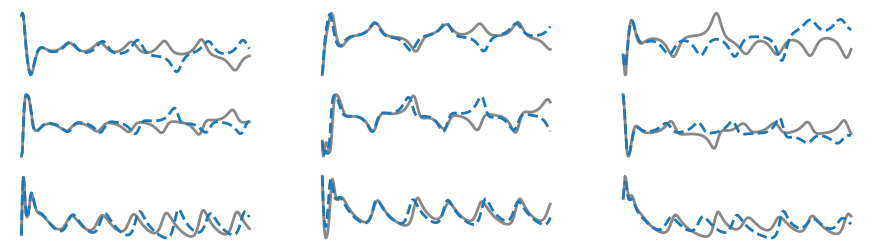

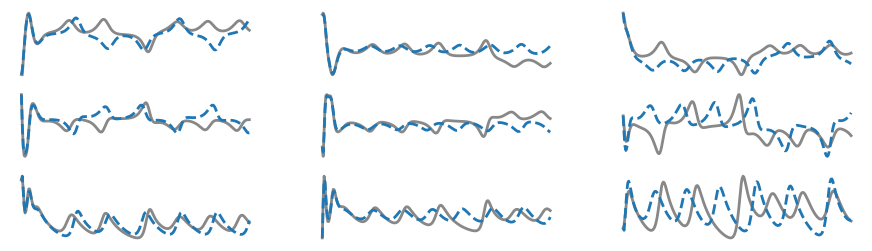

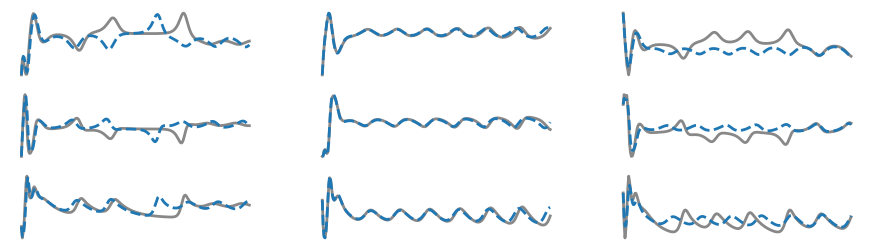

In [17]:
for ic in range(9):
    idxs = np.arange(ic*250,(ic+1)*250)
    
    z_sim = sindy_simulate(test_set_results['z'][250*ic], test_data['t'],
                           params['coefficient_mask']*test_set_results['sindy_coefficients'],
                           params['poly_order'], params['include_sine'])
    
    col_idx = ic % 3
    
    if ic % 3 == 0:
        plt.figure(figsize=(11,3))
    for i in range(3):
        row_idx = i
        subplot_idx = 3*row_idx + col_idx + 1
        plt.subplot(3,3,subplot_idx)
        plt.plot(test_data['t'], test_set_results['z'][idxs,i], color='#888888', linewidth=2)
        plt.plot(test_data['t'], z_sim[:,i], '--', linewidth=2)
        plt.xticks([])
        plt.yticks([])
#         plt.ylim(ylims[i])
        plt.axis('off')